<a href="https://colab.research.google.com/github/bonnefco/P8/blob/main/P8_BERT_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [367]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import ast
from scipy import stats
import tensorflow
from sklearn.model_selection import train_test_split

In [368]:
!pip install transformers
import transformers
from transformers import TFAutoModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [369]:
def plot_curves(history):
  #print(history.history.keys())
  # print(history.history['accuracy'])
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  return

In [370]:
df_effective_args = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P8/dataset/train_light.csv',encoding="utf-8",header=(0))
df_effective_args

,discourse_text,discourse_type,discourse_effectiveness
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,"On my perspective, I think that the face is a ...",Position,Adequate
2,I think that the face is a natural landform be...,Claim,Adequate
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,People thought that the face was formed by ali...,Counterclaim,Adequate
...,...,...,...
36672,For many people they don't like only asking on...,Claim,Adequate
36673,also people have different views and opinions ...,Claim,Adequate
36674,Advice is something that can impact a persons ...,Position,Adequate
36675,someone can use everything that many people sa...,Evidence,Ineffective


In [371]:
# Configuration
BATCH_SIZE = 16
MAX_LEN = 256 
DROPOUT = 0.1
LEARNING_RATE = 1e-5
EPOCHS = 1
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

In [372]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case = True, pad_token = '[PAD]')

credits : https://www.kaggle.com/code/iamleonie/feedback-prize-eda-starter-for-beginners

Get the sep_token from the tokenizer and create the input sequences from discourse_type and discourse_text.

sep_token - A special token separating two different sentences in the same input (see https://huggingface.co/docs/transformers/main_classes/tokenizer)

In [373]:
sep = tokenizer.sep_token
print(sep)

df_effective_args['discourse_type_SEP_discourse_text'] = df_effective_args.discourse_type + sep + df_effective_args.discourse_text
df_effective_args.head(3)

[SEP]


,discourse_text,discourse_type,discourse_effectiveness,discourse_type_SEP_discourse_text
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,"Position[SEP]On my perspective, I think that t..."
2,I think that the face is a natural landform be...,Claim,Adequate,Claim[SEP]I think that the face is a natural l...


Let's have a look at what the tokenizer does with one sample:

The function bert_encode() returns two arrays: input_ids andattention_mask

https://huggingface.co/docs/transformers/main_classes/tokenizer

*   input_ids — List of token ids to be fed to a model.

*    attention_mask — List of indices specifying which tokens should be attended to by the model (when return_attention_mask=True or if “attention_mask” is in self.model_input_names).

mdifier discourse effectuvness

In [374]:
df_effective_args["number"] = df_effective_args["discourse_effectiveness"].replace({"Ineffective": 0, "Adequate": 1, "Effective": 2})

In [375]:
print('Sample input sequence:')
sample_sequence = df_effective_args['discourse_type_SEP_discourse_text'].iloc[0]
print(sample_sequence)

print('\nTokenized sequence:')
print(tokenizer.tokenize(sample_sequence))

token = tokenizer(sample_sequence, 
                  max_length         = MAX_LEN, 
                  truncation         = True, 
                  padding            = 'max_length',
                  add_special_tokens = True,
                  return_tensors     = "np"
                 )
    
print('\ninput_ids:')
print(len(token['input_ids']))
print('\nattention_mask:')
print(token['attention_mask'])

Sample input sequence:
Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. 

Tokenized sequence:
['lead', '[SEP]', 'hi', ',', 'i', "'", 'm', 'isaac', ',', 'i', "'", 'm', 'going', 'to', 'be', 'writing', 'about', 'how', 'this', 'face', 'on', 'mars', 'is', 'a', 'natural', 'land', '##form', 'or', 'if', 'there', 'is', 'life', 'on', 'mars', 'that', 'made', 'it', '.', 'the', 'story', 'is', 'about', 'how', 'nasa', 'took', 'a', 'picture', 'of', 'mars', 'and', 'a', 'face', 'was', 'seen', 'on', 'the', 'planet', '.', 'nasa', 'doesn', "'", 't', 'know', 'if', 'the', 'land', '##form', 'was', 'created', 'by', 'life', 'on', 'mars', ',', 'or', 'if', 'it', 'is', 'just', 'a', 'natural', 'land', '##form', '.']

input_ids:
1

attention_ma

In [376]:
def bert_encode(texts, tokenizer = tokenizer, max_len = MAX_LEN):

    token = tokenizer(texts, 
                      max_length         = max_len, 
                      truncation         = True, 
                      padding            = "max_length",
                      add_special_tokens = True,
                      return_tensors     = "tf")
        
    input_ids = token['input_ids']
    attention_mask = token['attention_mask']
    return input_ids[0], attention_mask[0]

In [377]:
print(bert_encode(sample_sequence, tokenizer, max_len = MAX_LEN))

(<tf.Tensor: shape=(256,), dtype=int32, numpy=
array([  101,  2599,   102,  7632,  1010,  1045,  1005,  1049,  7527,
        1010,  1045,  1005,  1049,  2183,  2000,  2022,  3015,  2055,
        2129,  2023,  2227,  2006,  7733,  2003,  1037,  3019,  2455,
       14192,  2030,  2065,  2045,  2003,  2166,  2006,  7733,  2008,
        2081,  2009,  1012,  1996,  2466,  2003,  2055,  2129,  9274,
        2165,  1037,  3861,  1997,  7733,  1998,  1037,  2227,  2001,
        2464,  2006,  1996,  4774,  1012,  9274,  2987,  1005,  1056,
        2113,  2065,  1996,  2455, 14192,  2001,  2580,  2011,  2166,
        2006,  7733,  1010,  2030,  2065,  2009,  2003,  2074,  1037,
        3019,  2455, 14192,  1012,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,  

In [378]:
tensorflow.keras.backend.clear_session()

input_ids = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "input_ids")
attention_mask = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "attention_mask")

transformer_layer = (transformers.TFAutoModel.from_pretrained(MODEL_NAME))

sequence_output = transformer_layer([input_ids, attention_mask])['last_hidden_state']

clf_output = sequence_output[:, 0, :]

clf_output = tensorflow.keras.layers.Dropout(DROPOUT)(clf_output)
out = tensorflow.keras.layers.Dense(3, activation='softmax')(clf_output)

model = tensorflow.keras.Model(inputs = [input_ids, attention_mask], 
              outputs = out)

model.compile(tensorflow.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['pre_classifier', 'dropout_19', 'classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [379]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

In [380]:
X = df_effective_args['discourse_type_SEP_discourse_text']
y = df_effective_args['number']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[100:150]
X_valid = X_valid[:10]
y_train = list(y_train[100:150])
y_valid= list(y_valid[:10])

In [381]:
X_train = X_train.transform(bert_encode)
X_valid = X_valid.transform(bert_encode)
X_train_words_encoded, X_train_mask = zip(*X_train)
X_valid_words_encoded, X_valid_mask = zip(*X_valid)

Dataset Valid

In [382]:
valid_input_words_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_valid_words_encoded)))
            .batch(5)
)


valid_input_mask_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_valid_mask)))
            .batch(5)
)

valid_output_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((y_valid))
            .batch(5)
)

data_valid_words_mask = tensorflow.data.Dataset.zip((valid_input_words_dataset, valid_input_mask_dataset))
data_valid = tensorflow.data.Dataset.zip((data_valid_words_mask, valid_output_dataset))
print(data_valid.element_spec)

# for x, y in data_valid :
#   print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', x)
#   print('???????????????????????????', y)

((TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Dataset train

In [383]:
train_input_words_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_train_words_encoded)))
            .batch(5)
)


train_input_mask_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_train_mask)))
            .batch(5)
)

train_output_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((y_train))
            .batch(5)
)

data_train_words_mask = tensorflow.data.Dataset.zip((train_input_words_dataset, train_input_mask_dataset))
data_train = tensorflow.data.Dataset.zip((data_train_words_mask, train_output_dataset))

print(data_train.element_spec)

((TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [384]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.05,
    patience=15,
    #mode='max',
    verbose=1)

history = model.fit(
    data_train, 
    epochs=3,
    #validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    #steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition]    
)

Epoch 1/3
10/10 [==============================] - 99s 9s/step - loss: 1.3283 - accuracy: 0.2400 - val_loss: 1.2751 - val_accuracy: 0.4000
Epoch 2/3
10/10 [==============================] - 79s 8s/step - loss: 0.8228 - accuracy: 0.6800 - val_loss: 1.3937 - val_accuracy: 0.6000
Epoch 3/3
10/10 [==============================] - 79s 8s/step - loss: 0.6941 - accuracy: 0.7200 - val_loss: 1.4613 - val_accuracy: 0.6000


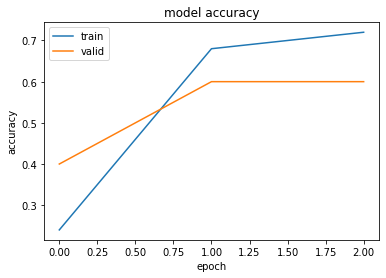

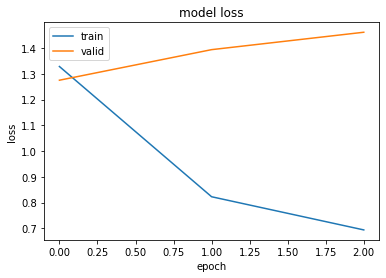

In [385]:
plot_curves(history)